# Image Stitching using OpenCV
Name: **Soham Bhattacharya** <br>
Reg. No.: **B2430059**

## Importing necessary libraries

In [5]:
# Image Stitching with OpenCV

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def show_image(img, title='Image'):
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

In [7]:
def draw_bold_matches(img1, kp1, img2, kp2, matches, inliers_mask=None, thickness=2):
    # Stack images side by side
    height = max(img1.shape[0], img2.shape[0])
    width = img1.shape[1] + img2.shape[1]
    vis = np.zeros((height, width, 3), dtype=np.uint8)
    vis[:img1.shape[0], :img1.shape[1]] = img1
    vis[:img2.shape[0], img1.shape[1]:] = img2

    # Draw lines between matching keypoints
    for i, m in enumerate(matches):
        if inliers_mask is not None and not inliers_mask[i]:
            continue  # skip non-inliers if mask provided

        pt1 = tuple(np.round(kp1[m.queryIdx].pt).astype(int))
        pt2 = tuple(np.round(kp2[m.trainIdx].pt).astype(int) + np.array([img1.shape[1], 0]))
        color = (0, 255, 0)  # Green line
        cv2.line(vis, pt1, pt2, color, thickness=thickness)
        cv2.circle(vis, pt1, 4, (255, 0, 0), -1)
        cv2.circle(vis, pt2, 4, (255, 0, 0), -1)

    return vis

## Reading the images

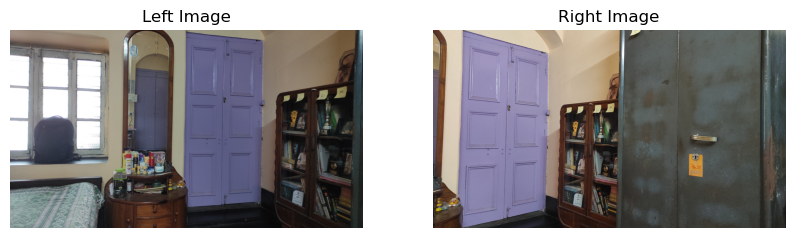

In [9]:
# Load input images (ensure they overlap)
img1 = cv2.imread('data/test1.jpg')   # left image
img2 = cv2.imread('data/test2.jpg')  # right image

# show_image(img1, "Left Image")
# show_image(img2, "Right Image")

# Plot side-by-side
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Left Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Right Image')
plt.axis('off')

# plt.tight_layout()
plt.show()

## Feature Detection and Description

In [10]:
# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Detect ORB keypoints and descriptors
orb = cv2.ORB_create(nfeatures=2000)

kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

## Feature Matching

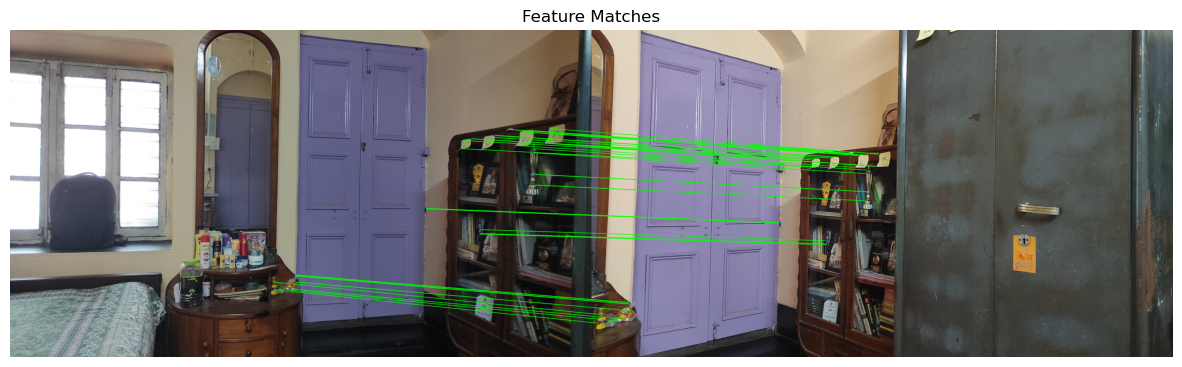

In [13]:
# Match features using Brute Force matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches (optional)
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=2)
img_matches = draw_bold_matches(img1, kp1, img2, kp2, matches[:50], thickness=3)
show_image(img_matches, "Feature Matches")

## Homography Estimation

In [14]:
# Find Homography
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

## Warping the image

In [15]:
# Warp right image to left image plane
height, width, channels = img1.shape
warped_img2 = cv2.warpPerspective(img2, H, (width + img2.shape[1], height))

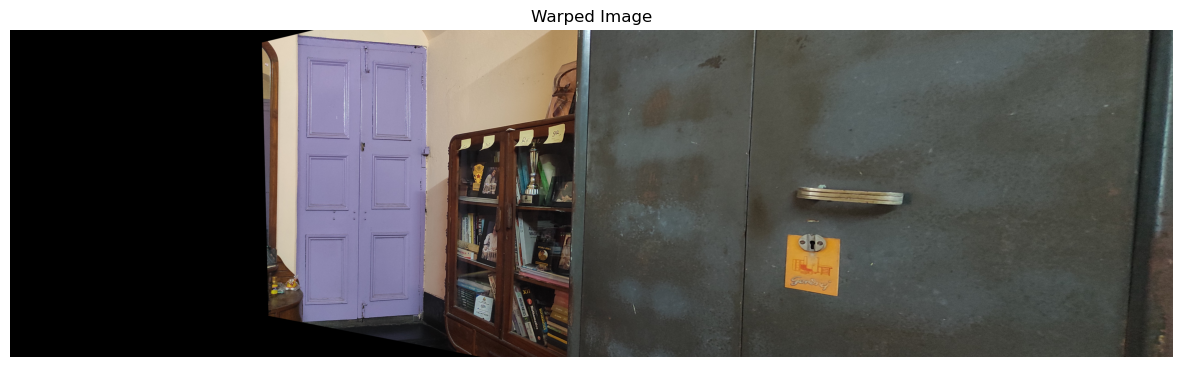

In [16]:
show_image(warped_img2, "Warped Image")

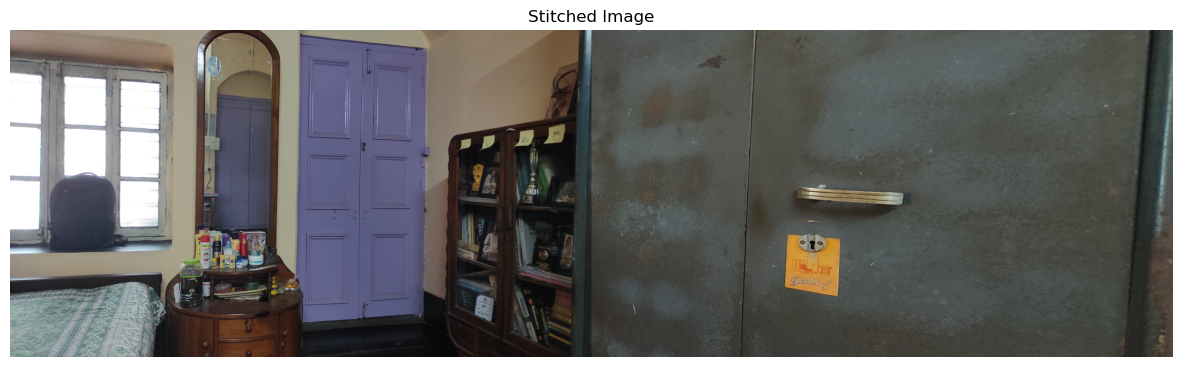

In [17]:
# Stitch the images
result = warped_img2.copy()
result[0:img1.shape[0], 0:img1.shape[1]] = img1

show_image(result, "Stitched Image")

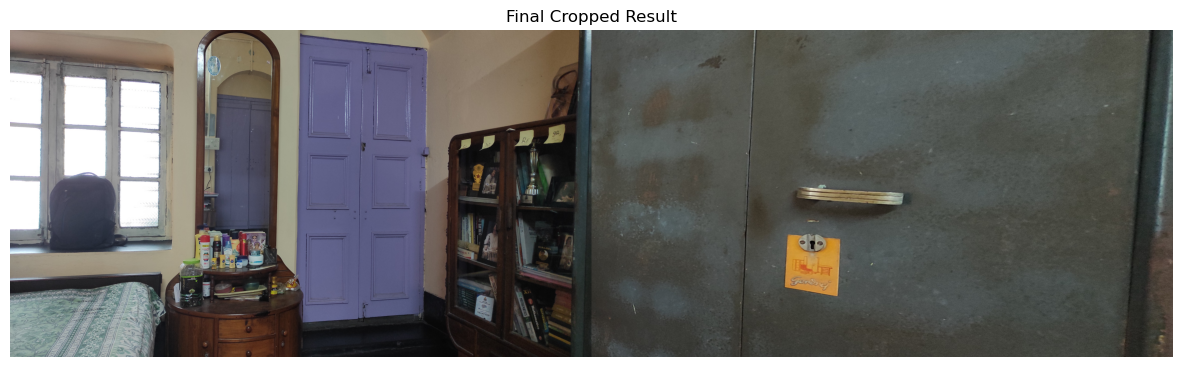

In [20]:
# Optional: Crop the result to remove black borders
def crop_black(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(contours[0])
        cropped = img[y:y+h, x:x+w]
        return cropped
    return img

final = crop_black(result)
show_image(final, "Final Cropped Result")

# THANK YOU